# Combined Datasets
For all the models

In [ ]:
"Here we will do a combined csv"
import pandas as pd
import glob

path = "/content/data"

files = glob.glob(path + "**/*.csv", recursive=True)
print("Found files:", files)

if not files:
    raise ValueError("No CSV files found. Check your path!")


dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df.to_csv("llm_inference_energy_consumption_combined.csv", index=False)
print("✅ Combined dataset saved. Energy column stats:")
print(df["energy_consumption_llm_gpu"].describe())


Found files: []


ValueError: No CSV files found. Check your path!

#Load and analyze the dataset

In [ ]:
df.head()

In [ ]:
df.describe().T


In [ ]:

df["energy_consumption_llm_gpu"].describe()
print(df["energy_consumption_llm_gpu"].unique()[:20])

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
print(df.shape)
print(df.info())
print(df.head())

print(df.describe())

#Check missing values
print(df.isna().sum())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(8,4))
sns.histplot(df["energy_consumption_llm_gpu"], bins=50, kde=True)
plt.title("GPU Energy Consumption Distribution")
plt.show()

# Correlation heatmap of numeric columns
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
plt.figure(figsize=(15,12))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
import numpy as np
df = df.copy()

# Parse timestamp
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# Convert likely-nanosecond durations -> seconds
for col in ["total_duration", "load_duration", "prompt_duration", "response_duration"]:
    if col in df.columns:
        s = pd.to_numeric(df[col], errors="coerce")
        # Heuristic: median >> 1e6 implies ns
        med = np.nanmedian(s) if np.isfinite(s).any() else np.nan
        if pd.notna(med) and med > 1e6:
            df[col + "_s"] = s / 1e9
        else:
            df[col + "_s"] = s

# Sanity check
df[["total_duration", "total_duration_s", "response_duration", "response_duration_s"]].head(3)

In [ ]:
# Step 2 — tokens and throughput features
import numpy as np
import pandas as pd

df = df.copy()

# Total tokens
df["total_tokens"] = (
    df["prompt_token_length"].fillna(0).astype(float)
    + df["response_token_length"].fillna(0).astype(float)
)

# Throughput (tokens/sec) and time per token
eps = 1e-9
if "response_duration_s" in df.columns and df["response_duration_s"].notna().any():
    denom = df["response_duration_s"].replace(0, eps)
    df["tokens_per_s"] = df["total_tokens"] / denom
    df["time_per_token_s"] = df["response_duration_s"] / df["response_token_length"].replace(0, np.nan)
else:
    denom = df["total_duration_s"].replace(0, eps)
    df["tokens_per_s"] = df["total_tokens"] / denom
    df["time_per_token_s"] = np.nan  # not available without response_duration_s

# Quick sanity check
cols = ["prompt_token_length","response_token_length","total_tokens","tokens_per_s","time_per_token_s"]
display(df[cols].head(5))
print(df[cols].describe().T)

#Feature Engineering

## Analysis

Before we decided to delete and keep these columns we did the analysis of the data by using a visualization tool from WatsonX Studio, by doing some correlations, scatters, etc... Here is an example
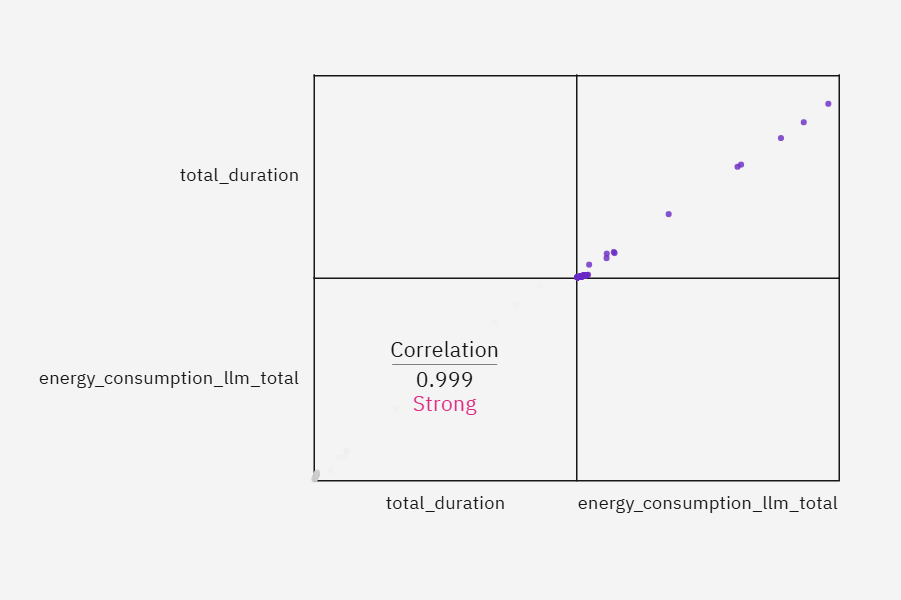

In [ ]:
df = pd.read_csv("/content/llm_inference_energy_consumption_combined.csv")

# Columns to drop
cols_to_drop_additional = [
    "szigriszt_pazos",
    "gutierrez_polini",
    "crawford",
    "osman",
    "gulpease_index",
    "wiener_sachtextformel",
    "syllable_count",
    "lexicon_count",
    "char_count",
    "letter_count",
    "polysyllabcount",
    "monosyllabcount",
    "question_marks",
    "exclamation_marks",
    "sentence_embedding_variance",
    "personal_pronouns",
    "named_entities",
    "adjectives",
    "adverbs",
    "questions_about_entities",
    "desc_complexity_ratio",
    "word_count_squared",
    "avg_sentence_length_cubed",
    "lexical_diversity",
        "index",
    "created_at",
    "prompt",
    "response",
    "type",
    "clock_duration",
    "start_time",
    "end_time",
    "word_count",
    "sentence_count",
    "avg_word_length",
    "word_diversity",
    "unique_word_count",
    "avg_sentence_length",
    "punctuation_count",
    "stop_word_count",
    "long_word_count",
    "named_entity_count",
    "noun_count",
    "verb_count",
    "adj_count",
    "adverb_count",
    "pronoun_count",
    "prop_adverbs",
    "prop_pronouns",
    "sentiment_polarity",
    "sentiment_subjectivity",
    "flesch_reading_ease",
    "flesch_kincaid_grade",
    "gunning_fog",
    "smog_index",
    "automated_readability_index",
    "coleman_liau_index",
    "linsear_write_formula",
    "dale_chall_readability_score",
    "text_standard",
    "spache_readability",
    "mcalpine_eflaw",
    "reading_time",
    "fernandez_huerta"
]

# Drop columns
df_final = df.drop(columns=cols_to_drop_additional, errors='ignore')

# Save final cleaned dataset
df_final.to_csv("llm_inference_energy_consumption_final.csv", index=False)

print("✅ Final cleaned dataset saved! Remaining columns:")
print(df_final.columns)

✅ Final cleaned dataset saved! Remaining columns:
Index(['model_name', 'total_duration', 'load_duration', 'prompt_token_length',
       'prompt_duration', 'response_token_length', 'response_duration',
       'energy_consumption_monitoring', 'energy_consumption_llm_cpu',
       'energy_consumption_llm_gpu', 'energy_consumption_llm_total',
       'energy_consumption_llm', 'length_x_complexity'],
      dtype='object')


In [ ]:
df_final.head()

,model_name,total_duration,load_duration,prompt_token_length,prompt_duration,response_token_length,response_duration,energy_consumption_monitoring,energy_consumption_llm_cpu,energy_consumption_llm_gpu,energy_consumption_llm_total,energy_consumption_llm,length_x_complexity
0,codellama:70b,6.644908e+11,8.751972e+09,50.0,5.139754e+09,343.0,6.504625e+11,0.000302,3.171568e-06,0.004406,0.004409,0.004409,0.000000
1,codellama:70b,8.203381e+11,1.846132e+06,47.0,5.117707e+09,427.0,8.150882e+11,0.000373,3.457907e-06,0.005509,0.005513,0.005513,0.000000
2,codellama:70b,2.638532e+12,1.575359e+06,43.0,5.086785e+09,1311.0,2.633311e+12,0.001200,1.100193e-05,0.017680,0.017691,0.017691,0.521990
3,codellama:70b,1.890956e+11,1.076175e+06,92.0,5.799735e+09,98.0,1.831649e+11,0.000087,8.265229e-07,0.001271,0.001272,0.001272,2.469388
4,codellama:70b,2.170492e+11,1.562773e+06,42.0,5.120227e+09,114.0,2.117904e+11,0.000100,9.235695e-07,0.001476,0.001477,0.001477,0.652832


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


df = df_final.copy()

# -------------------------------
# Clean and convert types
# -------------------------------
# Convert durations to seconds (assuming nanoseconds)
df["total_duration_sec"] = df["total_duration"] / 1e9
df["load_duration_sec"] = df["load_duration"] / 1e9
df["prompt_duration_sec"] = df["prompt_duration"] / 1e9
df["response_duration_sec"] = df["response_duration"] / 1e9

# Fill missing numeric values with median
numeric_cols = df.select_dtypes(include="float64").columns
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# -------------------------------
# Feature Engineering
# -------------------------------
df["inference_time"] = df["total_duration_sec"]

# Power draw in watts
df["power_draw_gpu"] = (df["energy_consumption_llm_gpu"] * 1000) / (df["inference_time"] / 3600)
df["power_draw_cpu"] = (df["energy_consumption_llm_cpu"] * 1000) / (df["inference_time"] / 3600)
df["power_draw_total"] = (df["energy_consumption_llm_total"] * 1000) / (df["inference_time"] / 3600)

# Token features
df["total_tokens"] = df["prompt_token_length"] + df["response_token_length"]
df["prompt_response_ratio"] = df["prompt_token_length"] / df["response_token_length"].replace(0,1)

# -------------------------------
# Encode categorical variables
# -------------------------------
df = pd.get_dummies(df, columns=["model_name"], drop_first=True)

/tmp/ipython-input-4080977057.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [ ]:
df.head()

,total_duration,load_duration,prompt_token_length,prompt_duration,response_token_length,response_duration,energy_consumption_monitoring,energy_consumption_llm_cpu,energy_consumption_llm_gpu,energy_consumption_llm_total,...,load_duration_sec,prompt_duration_sec,response_duration_sec,inference_time,power_draw_gpu,power_draw_cpu,power_draw_total,total_tokens,prompt_response_ratio,model_name_gemma:7b
0,6.644908e+11,8.751972e+09,50.0,5.139754e+09,343.0,6.504625e+11,0.000302,3.171568e-06,0.004406,0.004409,...,8.751972,5.139754,650.462495,664.490760,23.868657,0.017183,23.885840,393.0,0.145773,False
1,8.203381e+11,1.846132e+06,47.0,5.117707e+09,427.0,8.150882e+11,0.000373,3.457907e-06,0.005509,0.005513,...,0.001846,5.117707,815.088191,820.338145,24.177391,0.015175,24.192565,474.0,0.110070,False
2,2.638532e+12,1.575359e+06,43.0,5.086785e+09,1311.0,2.633311e+12,0.001200,1.100193e-05,0.017680,0.017691,...,0.001575,5.086785,2633.310982,2638.531817,24.122767,0.015011,24.137778,1354.0,0.032799,False
3,1.890956e+11,1.076175e+06,92.0,5.799735e+09,98.0,1.831649e+11,0.000087,8.265229e-07,0.001271,0.001272,...,0.001076,5.799735,183.164868,189.095606,24.193571,0.015735,24.209306,190.0,0.938776,False
4,2.170492e+11,1.562773e+06,42.0,5.120227e+09,114.0,2.117904e+11,0.000100,9.235695e-07,0.001476,0.001477,...,0.001563,5.120227,211.790388,217.049231,24.483591,0.015318,24.498909,156.0,0.368421,False


In [ ]:
print(df_final["total_duration"].describe())
print(df_final["load_duration"].describe())


count    2.160000e+03
mean     5.706921e+10
std      2.259550e+11
min      8.503162e+08
25%      7.005951e+09
50%      1.053097e+10
75%      1.255724e+10
max      3.250657e+12
Name: total_duration, dtype: float64
count    2.160000e+03
mean     1.215597e+07
std      2.611996e+08
min      7.718280e+05
25%      1.607598e+06
50%      1.753655e+06
75%      1.920646e+06
max      8.751972e+09
Name: load_duration, dtype: float64


#Understand distributions and correlations for the final dataset

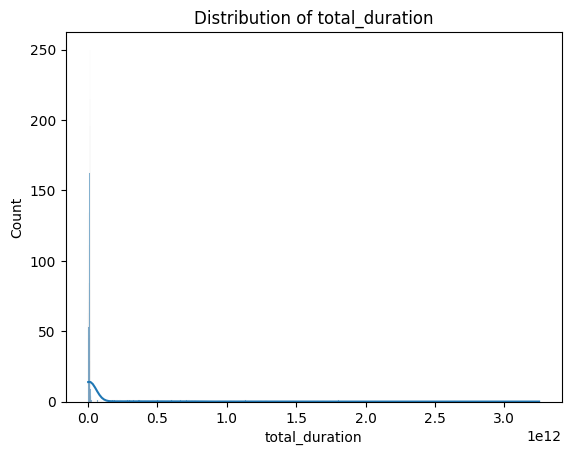

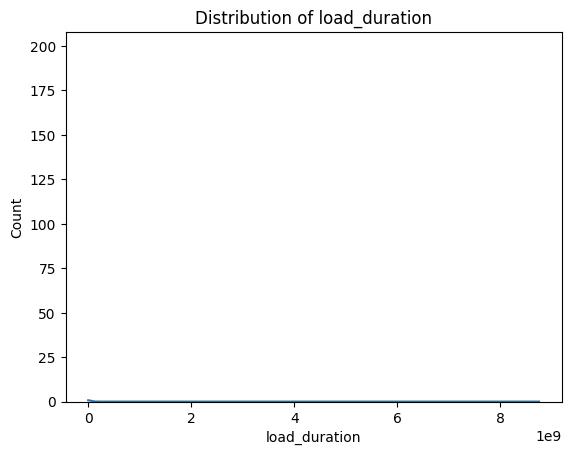

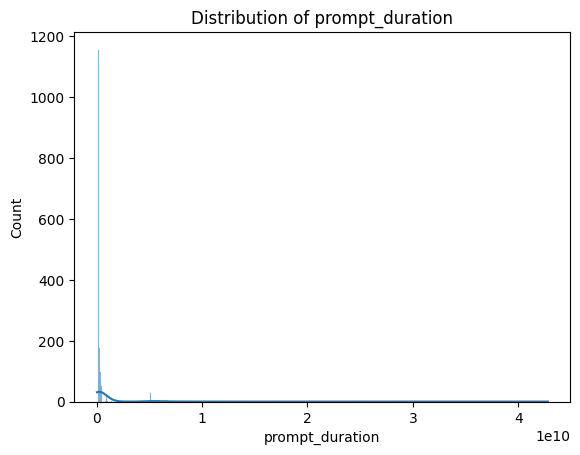

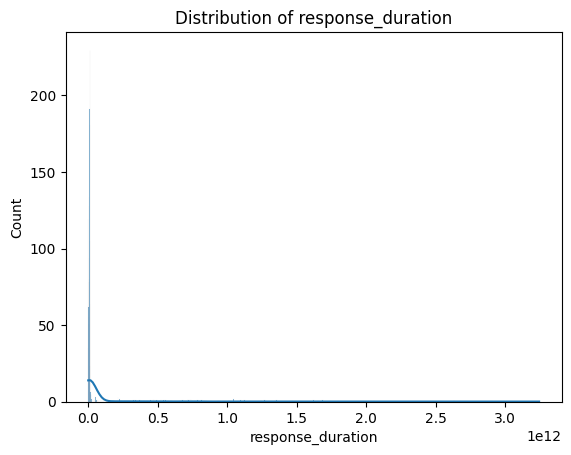

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for durations and token lengths
num_cols = ['total_duration', 'load_duration', 'prompt_duration', 'response_duration']
for col in num_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

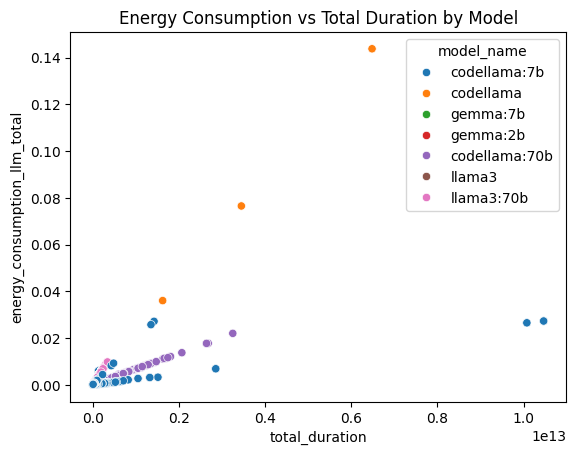

In [ ]:
sns.scatterplot(data=df_final, x='total_duration', y='energy_consumption_llm_total', hue='model_name')
plt.title('Energy Consumption vs Total Duration by Model')
plt.show()

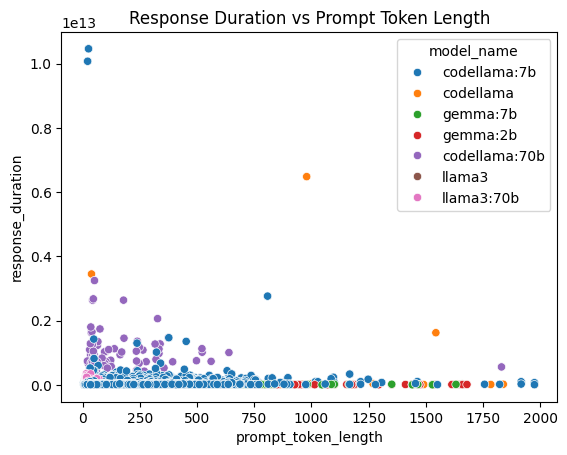

In [ ]:
sns.scatterplot(data=df_final, x='prompt_token_length', y='response_duration', hue='model_name')
plt.title('Response Duration vs Prompt Token Length')
plt.show()

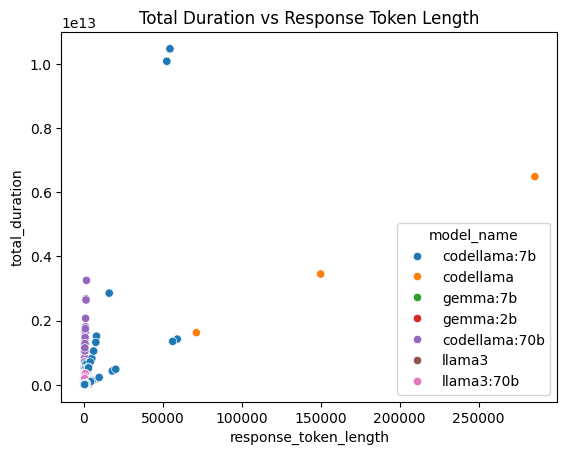

In [ ]:
sns.scatterplot(data=df_final, x='response_token_length', y='total_duration', hue='model_name')
plt.title('Total Duration vs Response Token Length')
plt.show()

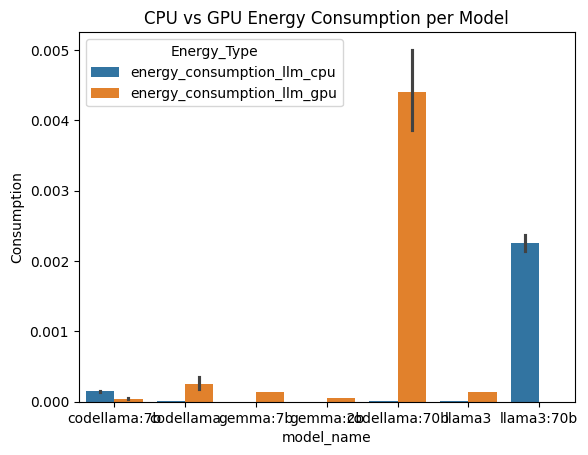

In [ ]:
df_melted = df_final.melt(id_vars='model_name',
                    value_vars=['energy_consumption_llm_cpu', 'energy_consumption_llm_gpu'],
                    var_name='Energy_Type', value_name='Consumption')

sns.barplot(data=df_melted, x='model_name', y='Consumption', hue='Energy_Type')
plt.title('CPU vs GPU Energy Consumption per Model')
plt.show()

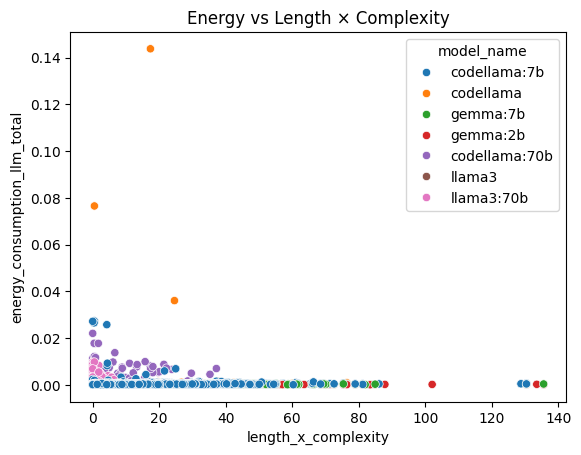

In [ ]:
sns.scatterplot(data=df_final, x='length_x_complexity', y='energy_consumption_llm_total', hue='model_name')
plt.title('Energy vs Length × Complexity')
plt.show()

In [ ]:
df_final.corr(numeric_only=True)['energy_consumption_llm_total'].sort_values(ascending=False)

,energy_consumption_llm_total
energy_consumption_llm_total,1.000000
energy_consumption_llm,1.000000
energy_consumption_llm_gpu,0.857470
response_token_length,0.845595
response_duration,0.624766
total_duration,0.617710
energy_consumption_monitoring,0.541102
energy_consumption_llm_cpu,0.497453
prompt_token_length,0.075086
prompt_duration,0.061912


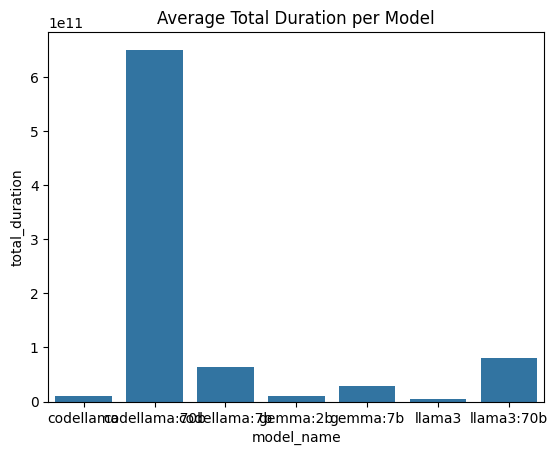

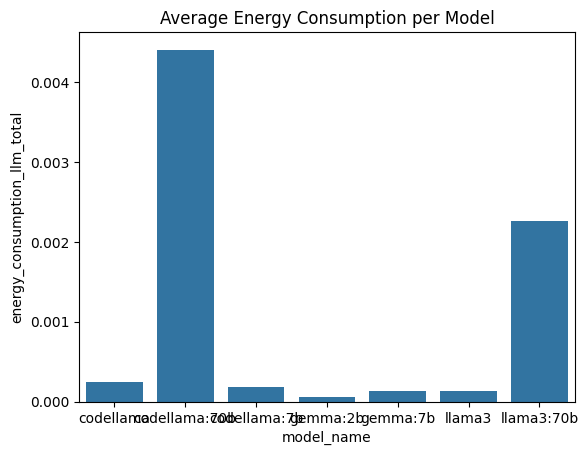

In [ ]:
summary = df_final.groupby('model_name')[['total_duration', 'energy_consumption_llm_total']].mean().reset_index()

sns.barplot(data=summary, x='model_name', y='total_duration')
plt.title('Average Total Duration per Model')
plt.show()

sns.barplot(data=summary, x='model_name', y='energy_consumption_llm_total')
plt.title('Average Energy Consumption per Model')
plt.show()

<Axes: >

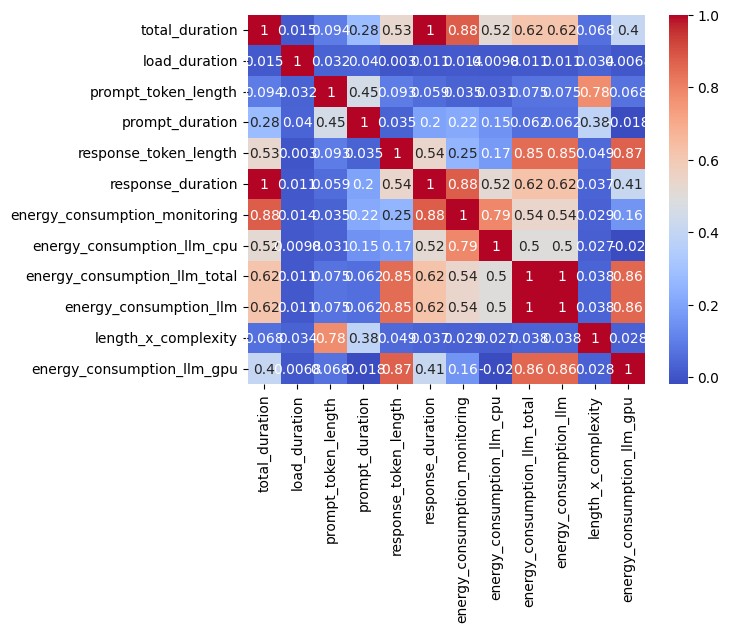

In [ ]:
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap='coolwarm')

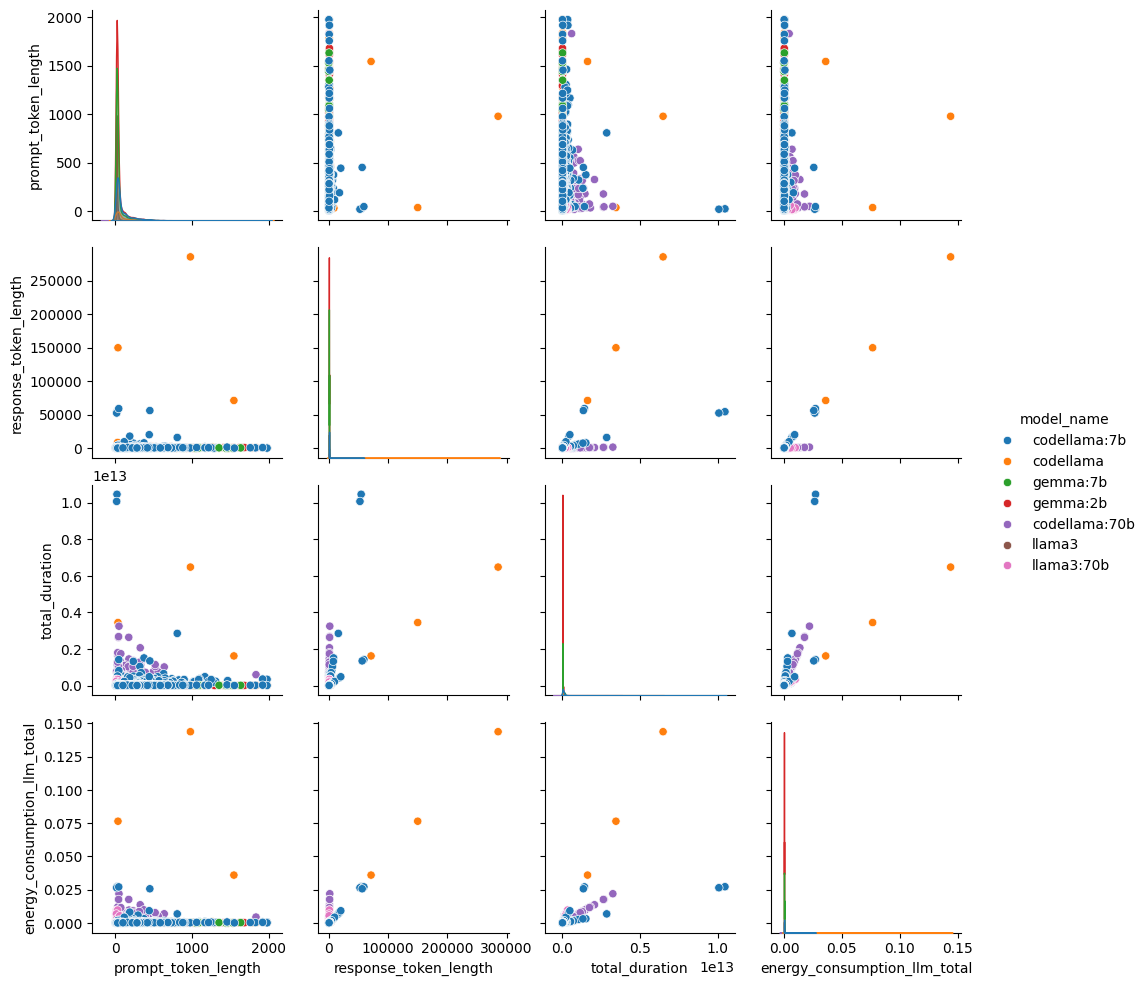

In [ ]:
sns.pairplot(df_final, vars=['prompt_token_length','response_token_length','total_duration','energy_consumption_llm_total'], hue='model_name')


#Model Training

In [ ]:
# === Training + Metrics + Saving (LinReg + RF, per-request & per-token) ===

import os, numpy as np, pandas as pd, joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    recall_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# -----------------------------
# 0) Chargement du dataset
# -----------------------------
PATH = "/content/llm_inference_energy_consumption_final.csv"
assert os.path.exists(PATH), "Le fichier llm_inference_energy_consumption_final.csv doit être dans /content."
df = pd.read_csv(PATH)

# -----------------------------
# 1) Feature engineering léger
# -----------------------------
def to_seconds(col_name: str):
    s = pd.to_numeric(df[col_name], errors="coerce")
    if s.notna().any():
        med = np.nanmedian(s)
        # si très grand, on suppose des nanosecondes
        return s / 1e9 if (np.isfinite(med) and med > 1e6) else s
    return s

for c in ["total_duration", "load_duration", "prompt_duration", "response_duration"]:
    if c in df.columns:
        new_col = c + "_s"
        if new_col not in df.columns:
            df[new_col] = to_seconds(c)

# Tokens totaux
df["total_tokens"] = (
    df.get("prompt_token_length", 0).fillna(0).astype(float)
  + df.get("response_token_length", 0).fillna(0).astype(float)
)

# -----------------------------
# 2) Définition des cibles
# -----------------------------
TARGET_REQUEST = "energy_consumption_llm_total"
assert TARGET_REQUEST in df.columns, "La colonne energy_consumption_llm_total doit être présente."
df = df[df[TARGET_REQUEST].notna()].copy()

df["energy_per_token_kWh"] = np.where(
    df["total_tokens"] > 0,
    df[TARGET_REQUEST] / df["total_tokens"],
    np.nan
)

# -----------------------------
# 3) Sélection des features (sans fuite)
# -----------------------------
ban_cols = {
    "energy_consumption_llm_total","energy_consumption_llm",
    "energy_consumption_llm_cpu","energy_consumption_llm_gpu",
    "energy_consumption_monitoring",
    "power_draw_cpu","power_draw_gpu","power_draw_total",
    "energy_per_token_kWh"
}

num_candidates = [
    "prompt_token_length","response_token_length","total_tokens",
    "total_duration_s","prompt_duration_s","response_duration_s","load_duration_s",
    "length_x_complexity"
]
cat_candidates = ["model_name","type"]

num_features = [c for c in num_candidates if c in df.columns and c not in ban_cols]
cat_features = [c for c in cat_candidates if c in df.columns]

X_base = df[num_features + cat_features].copy()
for c in num_features:
    X_base[c] = pd.to_numeric(X_base[c], errors="coerce").fillna(X_base[c].median())

# -----------------------------
# 4) Préprocesseur commun
# -----------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ],
    remainder="drop"
)

# -----------------------------
# Helpers métriques
# -----------------------------
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-12, None))) * 100)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

def class_metrics_from_continuous(y_true, y_pred, n_classes=3):
    """
    Discrétise y_true en n_classes (quantiles) -> labels 0..n-1
    Applique les mêmes bornes à y_pred -> labels prédits.
    Retourne: accuracy, recall_macro, recall_weighted
    """
    qs = np.linspace(0, 1, n_classes + 1)
    bounds = np.quantile(y_true, qs)
    bounds[0]  -= 1e-15
    bounds[-1] += 1e-15

    def to_class(v):
        for i in range(n_classes):
            if bounds[i] < v <= bounds[i+1]:
                return i
        return n_classes - 1

    y_true_cls = np.array([to_class(v) for v in y_true])
    y_pred_cls = np.array([to_class(v) for v in y_pred])

    acc = accuracy_score(y_true_cls, y_pred_cls)
    rec_macro = recall_score(y_true_cls, y_pred_cls, average="macro", zero_division=0)
    rec_weighted = recall_score(y_true_cls, y_pred_cls, average="weighted", zero_division=0)
    return acc, rec_macro, rec_weighted

# =========================================================
# 5) PER-REQUEST : entraînement, métriques, sauvegarde
# =========================================================
df_req = df.copy()
X_req = X_base.loc[df_req.index]
y_req = df_req[TARGET_REQUEST].astype(float)

Xtr, Xte, ytr, yte = train_test_split(X_req, y_req, test_size=0.2, random_state=42)

models_req = {
    "LinReg": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

print("======== PER-REQUEST (kWh / requête) ========")
best_req_models = {}

for name, mdl in models_req.items():
    pipe = Pipeline(steps=[("pre", pre), ("model", mdl)])
    pipe.fit(Xtr, ytr)
    y_pred = pipe.predict(Xte)

    mae, rmse, mape, r2 = regression_metrics(yte, y_pred)
    acc, rec_m, rec_w = class_metrics_from_continuous(yte.values, y_pred)

    print(
        f"{name:11s} | "
        f"MAE={mae:.8f} | RMSE={rmse:.8f} | "
        f"MAPE={mape:.2f}% | R2={r2:.3f} | "
        f"Acc(terciles)={acc:.3f} | "
        f"Rec_macro={rec_m:.3f} | Rec_weighted={rec_w:.3f}"
    )

    best_req_models[name] = pipe

# Réentraîner sur tout le dataset (per-request)
req_linreg_final = Pipeline(steps=[("pre", pre), ("model", LinearRegression())])
req_linreg_final.fit(X_req, y_req)

req_rf_final = Pipeline(steps=[("pre", pre),
                               ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))])
req_rf_final.fit(X_req, y_req)

# Sauvegarde
REQ_LR_PATH      = "/content/model_energy_per_request_linreg.joblib"
REQ_RF_LIGHT_PATH = "/content/model_energy_per_request_rf_light.joblib"  # compressé

joblib.dump(req_linreg_final, REQ_LR_PATH)
joblib.dump(req_rf_final,    REQ_RF_LIGHT_PATH, compress=3)

# =========================================================
# 6) PER-TOKEN : entraînement, métriques, sauvegarde
# =========================================================
df_tok = df[df["energy_per_token_kWh"].notna() & (df["total_tokens"] > 0)].copy()
X_tok = X_base.loc[df_tok.index]
y_tok = df_tok["energy_per_token_kWh"].astype(float)

Xtr_t, Xte_t, ytr_t, yte_t = train_test_split(X_tok, y_tok, test_size=0.2, random_state=42)

models_tok = {
    "LinReg": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

print("\n======== PER-TOKEN (kWh / token) ========")
best_tok_models = {}

for name, mdl in models_tok.items():
    pipe = Pipeline(steps=[("pre", pre), ("model", mdl)])
    pipe.fit(Xtr_t, ytr_t)
    y_pred = pipe.predict(Xte_t)

    mae, rmse, mape, r2 = regression_metrics(yte_t, y_pred)
    acc, rec_m, rec_w = class_metrics_from_continuous(yte_t.values, y_pred)

    print(
        f"{name:11s} | "
        f"MAE={mae:.10f} | RMSE={rmse:.10f} | "
        f"MAPE={mape:.2f}% | R2={r2:.3f} | "
        f"Acc(terciles)={acc:.3f} | "
        f"Rec_macro={rec_m:.3f} | Rec_weighted={rec_w:.3f}"
    )

    best_tok_models[name] = pipe

# Réentraîner sur tout le dataset (per-token)
tok_linreg_final = Pipeline(steps=[("pre", pre), ("model", LinearRegression())])
tok_linreg_final.fit(X_tok, y_tok)

tok_rf_final = Pipeline(steps=[("pre", pre),
                               ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))])
tok_rf_final.fit(X_tok, y_tok)

# Sauvegarde
TOK_LR_PATH       = "/content/model_energy_per_token_linreg.joblib"
TOK_RF_LIGHT_PATH = "/content/model_energy_per_token_rf_light.joblib"  # compressé

joblib.dump(tok_linreg_final, TOK_LR_PATH)
joblib.dump(tok_rf_final,    TOK_RF_LIGHT_PATH, compress=3)

# =========================================================
# 7) Tailles des fichiers
# =========================================================
def size_mb(path): return os.path.getsize(path) / (1024 * 1024)

print("\n======== TAILLES DES MODELES ========")
for p in [REQ_LR_PATH, REQ_RF_LIGHT_PATH, TOK_LR_PATH, TOK_RF_LIGHT_PATH]:
    print(f"{os.path.basename(p):35s}: {size_mb(p):.4f} MB")

print("\nModèles générés")
print(" - model_energy_per_request_linreg.joblib")
print(" - model_energy_per_request_rf_light.joblib")
print(" - model_energy_per_token_linreg.joblib")
print(" - model_energy_per_token_rf_light.joblib")


======== PER-REQUEST (kWh / requête) ========
LinReg      | MAE=0.00006012 | RMSE=0.00025289 | MAPE=109.53% | R2=0.643 | Acc(terciles)=0.642 | Rec_macro=0.642 | Rec_weighted=0.642
RandomForest | MAE=0.00000292 | RMSE=0.00004863 | MAPE=1.90% | R2=0.987 | Acc(terciles)=0.993 | Rec_macro=0.993 | Rec_weighted=0.993

======== PER-TOKEN (kWh / token) ========
LinReg      | MAE=0.0000000513 | RMSE=0.0000002280 | MAPE=12.45% | R2=0.944 | Acc(terciles)=0.879 | Rec_macro=0.879 | Rec_weighted=0.879
RandomForest | MAE=0.0000000159 | RMSE=0.0000001048 | MAPE=3.54% | R2=0.988 | Acc(terciles)=0.962 | Rec_macro=0.962 | Rec_weighted=0.962

======== TAILLES DES MODELES ========
model_energy_per_request_linreg.joblib: 0.0037 MB
model_energy_per_request_rf_light.joblib: 500.6736 MB
model_energy_per_token_linreg.joblib: 0.0037 MB
model_energy_per_token_rf_light.joblib: 33.8576 MB

Modèles générés (à utiliser dans Streamlit / API) :
 - model_energy_per_request_linreg.joblib
 - model_energy_per_request_rf_li

## Testing Models

In [ ]:
# === Cellule : Tester un prompt avec les modèles sauvegardés (sans metadata) ===

import os, numpy as np, pandas as pd, joblib

# -----------------------------
# 0) Paths des modèles & dataset
# -----------------------------
DATA_PATH          = "/content/llm_inference_energy_consumption_final.csv"
REQ_LR_PATH        = "/content/model_energy_per_request_linreg.joblib"
REQ_RF_LIGHT_PATH  = "/content/model_energy_per_request_rf_light.joblib"
TOK_LR_PATH        = "/content/model_energy_per_token_linreg.joblib"
TOK_RF_LIGHT_PATH  = "/content/model_energy_per_token_rf_light.joblib"

for p in [DATA_PATH, REQ_LR_PATH, REQ_RF_LIGHT_PATH, TOK_LR_PATH, TOK_RF_LIGHT_PATH]:
    assert os.path.exists(p), f"Fichier manquant : {p}"

# -----------------------------
# 1) Rechargement dataset + mêmes features que training
# -----------------------------
df = pd.read_csv(DATA_PATH)

def to_seconds(series):
    s = pd.to_numeric(series, errors="coerce")
    if s.notna().any():
        med = np.nanmedian(s)
        return s / 1e9 if (np.isfinite(med) and med > 1e6) else s
    return s

for c in ["total_duration","load_duration","prompt_duration","response_duration"]:
    if c in df.columns and (c + "_s") not in df.columns:
        df[c + "_s"] = to_seconds(df[c])

df["total_tokens"] = (
    df.get("prompt_token_length", 0).fillna(0).astype(float)
  + df.get("response_token_length", 0).fillna(0).astype(float)
)

TARGET_REQUEST = "energy_consumption_llm_total"
df = df[df[TARGET_REQUEST].notna()].copy()

df["energy_per_token_kWh"] = np.where(
    df["total_tokens"] > 0,
    df[TARGET_REQUEST] / df["total_tokens"],
    np.nan
)

ban_cols = {
    "energy_consumption_llm_total","energy_consumption_llm",
    "energy_consumption_llm_cpu","energy_consumption_llm_gpu",
    "energy_consumption_monitoring",
    "power_draw_cpu","power_draw_gpu","power_draw_total",
    "energy_per_token_kWh"
}

num_candidates = [
    "prompt_token_length","response_token_length","total_tokens",
    "total_duration_s","prompt_duration_s","response_duration_s","load_duration_s",
    "length_x_complexity"
]
cat_candidates = ["model_name","type"]

num_features = [c for c in num_candidates if c in df.columns and c not in ban_cols]
cat_features = [c for c in cat_candidates if c in df.columns]

med_num = {}
for c in num_features:
    col = pd.to_numeric(df[c], errors="coerce")
    med_num[c] = float(col.median()) if col.notna().any() else 0.0

mode_cat = {}
for c in cat_features:
    mode_cat[c] = df[c].mode()[0] if c in df.columns and df[c].notna().any() else "unknown"

# Médiane des tokens de réponse pour approx
if "response_token_length" in df.columns and df["response_token_length"].notna().any():
    median_response_tokens = float(pd.to_numeric(df["response_token_length"], errors="coerce").median())
else:
    median_response_tokens = 120.0

req_lr       = joblib.load(REQ_LR_PATH)
req_rf_light = joblib.load(REQ_RF_LIGHT_PATH)
tok_lr       = joblib.load(TOK_LR_PATH)
tok_rf_light = joblib.load(TOK_RF_LIGHT_PATH)


def count_tokens(text: str) -> int:
    # Heuristique simple : ~1.3 tokens / mot
    return max(1, int(1.3 * len(str(text).split())))

def build_features_from_prompt(
    prompt: str,
    resp_tokens: float = None,
    model_name: str = None,
    machine_type: str = None,
) -> tuple:
    """
    Construit une ligne de features cohérente avec l'entraînement.
    - prompt_token_length, response_token_length, total_tokens dérivés du prompt
    - autres features numériques = médianes du dataset
    - features catégorielles = modes du dataset (sauf override)
    """
    if resp_tokens is None:
        resp_tokens = median_response_tokens

    pt = float(count_tokens(prompt))
    rt = float(resp_tokens)
    tt = pt + rt if (pt + rt) > 0 else 1.0

    if model_name is None:
        model_name = mode_cat.get("model_name", "unknown_model")
    if machine_type is None:
        machine_type = mode_cat.get("type", "unknown_type")

    row = {}

    # Numériques
    for c in num_features:
        if c == "prompt_token_length":
            row[c] = pt
        elif c == "response_token_length":
            row[c] = rt
        elif c == "total_tokens":
            row[c] = tt
        else:
            row[c] = med_num.get(c, 0.0)

    # Catégorielles
    for c in cat_features:
        if c == "model_name":
            row[c] = model_name
        elif c == "type":
            row[c] = machine_type
        else:
            row[c] = mode_cat.get(c, "unknown")

    X = pd.DataFrame([row], columns=num_features + cat_features)
    return X, int(pt), int(rt), int(tt)


def predict_for_prompt(prompt: str):
    X, pt, rt, tt = build_features_from_prompt(prompt)

    # Prédictions brutes
    e_req_lr_raw  = float(req_lr.predict(X)[0])
    e_req_rf_raw  = float(req_rf_light.predict(X)[0])
    e_tok_lr_raw  = float(tok_lr.predict(X)[0])
    e_tok_rf_raw  = float(tok_rf_light.predict(X)[0])

    # Clamp à 0 kWh (physique)
    e_req_lr  = max(0.0, e_req_lr_raw)
    e_req_rf  = max(0.0, e_req_rf_raw)
    e_tok_lr  = max(0.0, e_tok_lr_raw)
    e_tok_rf  = max(0.0, e_tok_rf_raw)

    print("======= TEST DU PROMPT =======")
    print(f"Prompt : {prompt[:200]}{'...' if len(prompt) > 200 else ''}\n")
    print(f"Tokens prompt estimés   : {pt}")
    print(f"Tokens réponse estimés  : {rt}")
    print(f"Total tokens estimés    : {tt}\n")

    print("---- ÉNERGIE PAR REQUÊTE (kWh) ----")
    print(f"LinReg        : {e_req_lr:.8f} kWh  ({e_req_lr*1000:.4f} Wh)")
    print(f"RandomForest  : {e_req_rf:.8f} kWh  ({e_req_rf*1000:.4f} Wh)")

    print("\n---- ÉNERGIE PAR TOKEN (kWh/token) ----")
    print(f"LinReg        : {e_tok_lr:.10f} kWh/token")
    print(f"RandomForest  : {e_tok_rf:.10f} kWh/token")

    return {
        "prompt_tokens": pt,
        "response_tokens": rt,
        "total_tokens": tt,
        "e_req_linreg_kWh": e_req_lr,
        "e_req_rf_kWh": e_req_rf,
        "e_tok_linreg_kWh": e_tok_lr,
        "e_tok_rf_kWh": e_tok_rf,
    }

# ========= 👉 Notre prompt👇 =========
PROMPT = "hello"
# ==============================================
_ = predict_for_prompt(PROMPT)


======= TEST DU PROMPT =======
Prompt : hello

Tokens prompt estimés   : 1
Tokens réponse estimés  : 255
Total tokens estimés    : 256

---- ÉNERGIE PAR REQUÊTE (kWh) ----
LinReg        : 0.00000000 kWh  (0.0000 Wh)
RandomForest  : 0.00008954 kWh  (0.0895 Wh)

---- ÉNERGIE PAR TOKEN (kWh/token) ----
LinReg        : 0.0000000000 kWh/token
RandomForest  : 0.0000001737 kWh/token
